# Kaggle - Chest X-Ray Images (Pneumonia)

- This is my notebook for the Kaggle Pneumonia task.
- All the "Content" text was extracted from the Kaggle Pneumonia [link](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

## Context

- You can access the study behind the main principles of this machine learning classification case in http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5. 

## Content 

- Illustrative Examples of Chest X-Rays in Patients with Pneumonia
![](https://i.imgur.com/jZqpV51.png)

- The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

- The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

- Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

- For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


## Mount Drive to access the dataset uploaded in Google cloud service.

In [ ]:
from google.colab import drive

GOOGLE_DRIVE_MOUNT_DIR = "/content/drive"
drive.mount(GOOGLE_DRIVE_MOUNT_DIR, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [1]:
import tensorflow as tf
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import losses, optimizers, activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


# Dataset organization

- Some observations about the original dataset:

  - Is not normalized in terms of resolution;
  - Is not balanced,  that is, the "pneumonia" and "normal" class does not have a similar image quantity;
  - The following table shows the number of images for each class:


  | Class | Train | Validation | Test | TOTAL |
  | -- | -- | -- | -- | -- |
  | Normal | 1.342 | 8 | 234 | 1.584 |
  | Pneumonia| 3.876 | 8 | 390 | 4.274 |


- To normalize and fit in the neural model, I resized all images to 224x224 resolution.
- To improve the neural network classification performance, I balanced the dataset and increased the number of samples for validation and testing.

- The table below shows the new dataset distribution:


  | Class | Train | Validation | Test | TOTAL |
  | -- | -- | -- | -- | -- |
  | Normal | 1.183 | 200 | 200 | 1.583 |
  | Pneumonia| 1.183 | 200 | 200 | 1.583 |

In [ ]:
#dataset
TRAIN_PATH = "/content/drive/My Drive/Rede Neural/MY DATASETS/Pneumonia Dataset224x224/train"
VAL_PATH = "/content/drive/My Drive/Rede Neural/MY DATASETS/Pneumonia Dataset224x224/val"
TEST_PATH = "/content/drive/My Drive/Rede Neural/MY DATASETS/Pneumonia Dataset224x224/test"

In [ ]:
#checking the image shape
img = cv2.imread('/content/drive/My Drive/Rede Neural/MY DATASETS/Pneumonia Dataset224x224/val/NORMAL/IM-0017-0001.jpeg')
img.shape

(224, 224, 3)

# Model Customization

- As a neural model, I have chosen DenseNet201, with 21.46 in top-1 and 5.54 in top-5 errors, according to the ImageNet dataset.
- Fine-tuning techniques:
  - **GlobalAveragePooling2d**: This layer applied after the base model helps the network to learn the correlation between all the filters during the training process. More specifically, a GlobalAveragePooling2d feed the filter average value through the next layers.
  - **Dropout**: As a regularization method, the Dropout layer keeps a percentage of neurons turned off during the training process (chosen randomly at each epoch). This process avoids co-dependencies between parameters that can lead neurons to overfitting. 

In [2]:
#number of classes
CLASSES = 2

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape = (224,224,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#training all the layers
for layer in base_model.layers:
  layer.trainable = True
      
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])

74842112/74836368 [==============================] - 1s 0us/step


In the code cell above, I imported the pre-trained DenseNet model with the weights from the ImageNet dataset. It means that DenseNet can recognize some crucial aspects of an image like borders and other basic patterns. Utilizing these weights, I can train just the output layer that contains the fine tunning technics and the two classification classes. However, to improve the classification performance, I defined all the layers as "trainable" so the model can learn the specific patterns of Pneumonia images.

In [3]:
#visualize trainable layers
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 zero_padding2d True
2 conv1/conv True
3 conv1/bn True
4 conv1/relu True
5 zero_padding2d_1 True
6 pool1 True
7 conv2_block1_0_bn True
8 conv2_block1_0_relu True
9 conv2_block1_1_conv True
10 conv2_block1_1_bn True
11 conv2_block1_1_relu True
12 conv2_block1_2_conv True
13 conv2_block1_concat True
14 conv2_block2_0_bn True
15 conv2_block2_0_relu True
16 conv2_block2_1_conv True
17 conv2_block2_1_bn True
18 conv2_block2_1_relu True
19 conv2_block2_2_conv True
20 conv2_block2_concat True
21 conv2_block3_0_bn True
22 conv2_block3_0_relu True
23 conv2_block3_1_conv True
24 conv2_block3_1_bn True
25 conv2_block3_1_relu True
26 conv2_block3_2_conv True
27 conv2_block3_concat True
28 conv2_block4_0_bn True
29 conv2_block4_0_relu True
30 conv2_block4_1_conv True
31 conv2_block4_1_bn True
32 conv2_block4_1_relu True
33 conv2_block4_2_conv True
34 conv2_block4_concat True
35 conv2_block5_0_bn True
36 conv2_block5_0_relu True
37 conv2_block5_1_conv True
38 conv2_block5_1_bn True
3

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

# Data preparation

In [ ]:
WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 32


# data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255)

val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical',
    shuffle=True)
    
validation_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

train_generator.class_indices


Found 2366 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

# Initializing Training

In [ ]:
EPOCHS = 20

filepath = "/content/drive/My Drive/Rede Neural/Checkpoints/Pneumonia Classification/best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks_list)

Epoch 1/20
74/74 [==============================] - ETA: 0s - loss: 0.1895 - acc: 0.9336 
Epoch 00001: val_acc improved from -inf to 0.56000, saving model to /content/drive/My Drive/Rede Neural/Checkpoints/Pneumonia Classification/best_weights.hdf5
74/74 [==============================] - 1397s 19s/step - loss: 0.1895 - acc: 0.9336 - val_loss: 6.0059 - val_acc: 0.5600
Epoch 2/20
74/74 [==============================] - ETA: 0s - loss: 0.1183 - acc: 0.9607
Epoch 00002: val_acc improved from 0.56000 to 0.87750, saving model to /content/drive/My Drive/Rede Neural/Checkpoints/Pneumonia Classification/best_weights.hdf5
74/74 [==============================] - 93s 1s/step - loss: 0.1183 - acc: 0.9607 - val_loss: 0.5046 - val_acc: 0.8775
Epoch 3/20
74/74 [==============================] - ETA: 0s - loss: 0.0723 - acc: 0.9751
Epoch 00003: val_acc did not improve from 0.87750
74/74 [==============================] - 86s 1s/step - loss: 0.0723 - acc: 0.9751 - val_loss: 0.8987 - val_acc: 0.6475
E

# Plot History of training

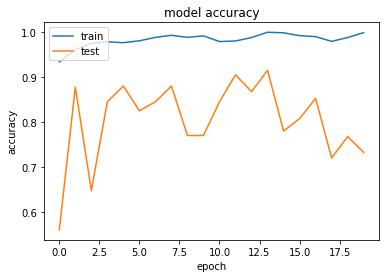

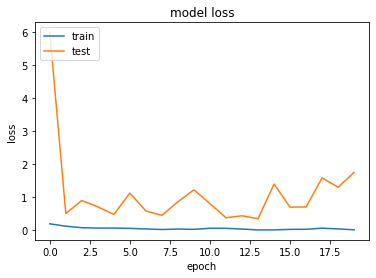

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Reload best checkpoint and Confusion Matrix

In [ ]:
model2 = load_model('/content/drive/My Drive/Rede Neural/Checkpoints/Pneumonia Classification/best_weights.hdf5')

Y_pred = model2.predict(test_generator, batch_size=BATCH_SIZE, verbose=1, steps=len(test_generator), workers=0)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_generator.classes, y_pred, digits=4, target_names=target_names))

13/13 [==============================] - 203s 16s/step
Confusion Matrix
[[195   5]
 [  9 191]]
Classification Report
              precision    recall  f1-score   support

      NORMAL     0.9559    0.9750    0.9653       200
   PNEUMONIA     0.9745    0.9550    0.9646       200

    accuracy                         0.9650       400
   macro avg     0.9652    0.9650    0.9650       400
weighted avg     0.9652    0.9650    0.9650       400

